# Popular Data Science Questions

###   Our goal in this project is to use [Data Science Stack Exchange](https://datascience.stackexchange.com/) to determine what content should a data science education company create, based on interest by subject.

### Stack Exchange

## What kind of questions are welcome on this site?
On DSSE's help center's [section on questions](https://datascience.stackexchange.com/help/asking) , we can read that we should:

- Avoid subjective questions.
- - Ask practical questions about Data Science — there are adequate sites for theoretical questions.
- Ask specific questions.
- Make questions relevant to others.
All of these characteristics, if employed, should be helpful attributes to our goal.

In the help center we also learned that in addition to the sites mentioned in the Learn section, there are other two sites that are relevant:

- [Open Data](https://opendata.stackexchange.com/help/on-topic) (Dataset requests)
- [Computational Science](https://scicomp.stackexchange.com/help/on-topic) (Software packages and algorithms in applied mathematics)

### What, other than questions, does DSSE's [home](https://datascience.stackexchange.com/) subdivide into?

On the [home page](https://datascience.stackexchange.com/) we can see that we have four sections:
- [Questions](https://datascience.stackexchange.com/questions) — a list of all questions asked;
- [Tags](https://datascience.stackexchange.com/tags) — a list of tags (keywords or labels that categorize questions);


- [Users](https://datascience.stackexchange.com/users) — a list of users;
- [Unanswered](https://datascience.stackexchange.com/unanswered) — a list of unanswered questions;
The tagging system used by Stack Exchange looks just like what we need to solve this problem as it allow us to quantify how many questions are asked about each subject.

Something else we can learn from exploring the help center, is that Stack Exchange's sites are heavily moderated by the community; this gives us some confidence in using the tagging system to derive conclusions.

### What information is available in each post?

Looking, just as an example, at [this](https://datascience.stackexchange.com/questions/19141/linear-model-to-generate-probability-of-each-possible-output?rq=1]) question, some of the information we see is:

For both questions and answers:
- The posts's score;
- The posts's title;
- The posts's author;
- The posts's body;

For questions only:
- How many users have it on their "
- The last time the question as active;
- How many times the question was viewed;
- Related questions;
- The question's tags;

### Stack exchange Data explorer

Stack Exchange provides a public data base for each of its websites. [Here](https://data.stackexchange.com/datascience/query/new) a link to query and explore Data Science Stack Exchange's database.




Perusing the table names, a few stand out as relevant for our goal:

- Posts
- PostTags
- Tags
- TagSynonyms

Running a few exploratory queries, leads us to focus our efforts on Posts table. For examples, the Tags table looked very promising as it tells us how many times each tag was used, but there's no way to tell just from this if the interest in these tags is recent or a thing from the past.

The posts table has a lot of columns. We'll be focusing our attention on those that seem relevant towards our goal:

- Id: An identification number for the post.
- PostTypeId: An identification number for the type of post.

- CreationDate: The date and time of creation of the post.

- Score: The post's score.
- ViewCount: How many times the post was viewed.
- Tags: What tags were used.
- AnswerCount: How many answers the question got (only applicable to question posts).
- FavoriteCount: How many times the question was favored (only applicable to question posts).

Note that with the exception of the tags column, the last few columns contain information about how popular the post is — the kind of information we're after.

Due to their low volume, anything that isn't questions or answers is mostly inconsequential. Even if it happens to be the case that such kind of posts is immensely popular, they would just be outliers and not relevant to us. We'll then just focus on the questions.

Since we're only interested in recent posts, we'll limit our analysis to the posts of 2019.



## Getting The Data

 Since we focus only on questions and limit our analysis to the posts of 2019.
 we will run a query against the SEDE DSSE database that extracts the columns listed above for all the questions in 2019. 

SELECT Id, CreationDate,
       Score, ViewCount, Tags,
      
       AnswerCount, FavoriteCount  
       
 FROM posts
 
 WHERE PostTypeId = 1 AND YEAR(CreationDate) = 2019;

The result of the query was stored in a file called 2019_questions.csv

## Exploring the Data

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [21]:
questions = pd.read_csv("2019_questions.csv", parse_dates=["CreationDate"])

In [22]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


We see that only FavoriteCount has missing values. A missing value on this column probably means that the question was is not present in any users' favorite list, so we can replace the missing values with zero.

The types seem adequate for every column, however, after we fill in the missing values on FavoriteCount, there is no reason to store the values as floats.

Since the object dtype is a catch-all type, let's see what types the objects in questions["Tags"] are.

In [23]:
questions["Tags"].apply(lambda value: type(value)).unique()

array([<class 'str'>], dtype=object)

We see that every value in this column is a string. On Stack Exchange, each question can only have a maximum of five tags (source), so one way to deal with this column is to create five columns in questions called Tag1, Tag2, Tag3, Tag4, and Tag5 and populate the columns with the tags in each row.

However, since doesn't help is relating tags from one question to another, we'll just keep them as a list.

## Cleaning the Data
 
 

In [24]:
#Fill in the missing values in FavoriteCount with 0
questions.fillna(value={'FavoriteCount':0},inplace=True)

#Set the appropriate types of each column 
questions["FavoriteCount"]=questions["FavoriteCount"].astype(int)

#clean the Tags column
questions["Tags"]=questions["Tags"].str.replace("^<|>$", "").str.split("><")
questions.sample(3)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
6182,52884,2019-05-30 04:50:17,0,210,[neural-network],1,0
1434,45882,2019-02-20 14:15:55,2,1418,"[time-series, lstm, scalability]",1,0
3075,48111,2019-03-27 21:53:14,3,97,"[classification, scikit-learn, multilabel-clas...",1,0


## Most used and Most Viewed tags
    Next we will determine the most popular tags. We'll do so by considering two different popularity proxies: for each tag we'll count how many times the tag was used, and how many times a question with that tag was viewed.

In [25]:
#Count how many times each tag was used
tag_count=dict()

for tags in questions["Tags"]:
    for tag in tags:
        if tag in tag_count:
            tag_count[tag]+=1
        else:
            tag_count[tag]=1
            
tag_count

{'.net': 1,
 '3d-object-detection': 1,
 '3d-reconstruction': 9,
 'ab-test': 6,
 'accuracy': 89,
 'activation': 1,
 'activation-function': 44,
 'active-learning': 4,
 'activity-recognition': 5,
 'actor-critic': 21,
 'adaboost': 1,
 'aggregation': 12,
 'ai': 25,
 'alex-net': 5,
 'algorithms': 68,
 'allennlp': 2,
 'amazon-ml': 1,
 'anaconda': 20,
 'ann': 2,
 'annotation': 12,
 'anomaly': 4,
 'anomaly-detection': 92,
 'anonymization': 3,
 'anova': 2,
 'apache-hadoop': 13,
 'apache-nifi': 1,
 'apache-spark': 35,
 'arima': 11,
 'association-rules': 19,
 'attention-mechanism': 26,
 'auc': 3,
 'audio-recognition': 25,
 'autoencoder': 106,
 'automatic-summarization': 10,
 'automation': 4,
 'automl': 2,
 'aws': 20,
 'aws-lambda': 2,
 'azure-ml': 12,
 'backpropagation': 65,
 'batch-normalization': 29,
 'bayes-error': 1,
 'bayesian': 40,
 'bayesian-networks': 12,
 'bayesian-nonparametric': 2,
 'beginner': 27,
 'bert': 64,
 'bias': 19,
 'bigdata': 95,
 'binary': 26,
 'bioinformatics': 4,
 'books': 


For improved aesthetics, let's transform tag_count to a dataframe

In [26]:
tag_count = pd.DataFrame.from_dict(tag_count,orient="index")
tag_count.rename(columns={0:"Count"},inplace=True)
tag_count.head()





,Count
ngrams,7
bert,64
distribution,57
amazon-ml,1
backpropagation,65


Next we can sort this dataframe and visualize the top 20 results


In [27]:
most_used=tag_count.sort_values(by='Count').tail(20)
most_used

,Count
machine-learning-model,224
statistics,234
clustering,257
predictive-modeling,265
r,268
dataset,340
regression,347
pandas,354
lstm,402
time-series,466


 Let's visualize these data.

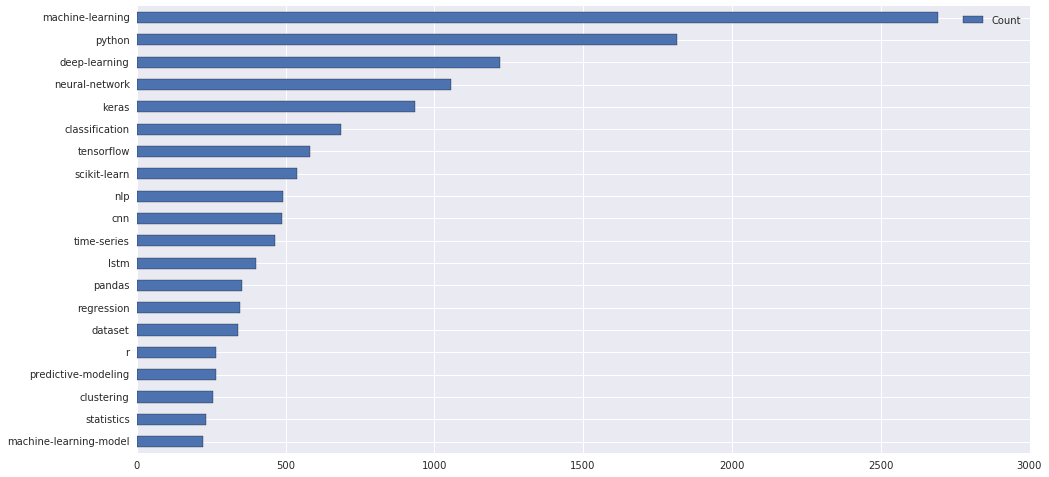

In [28]:
most_used.plot(kind='barh',figsize=(16,8))

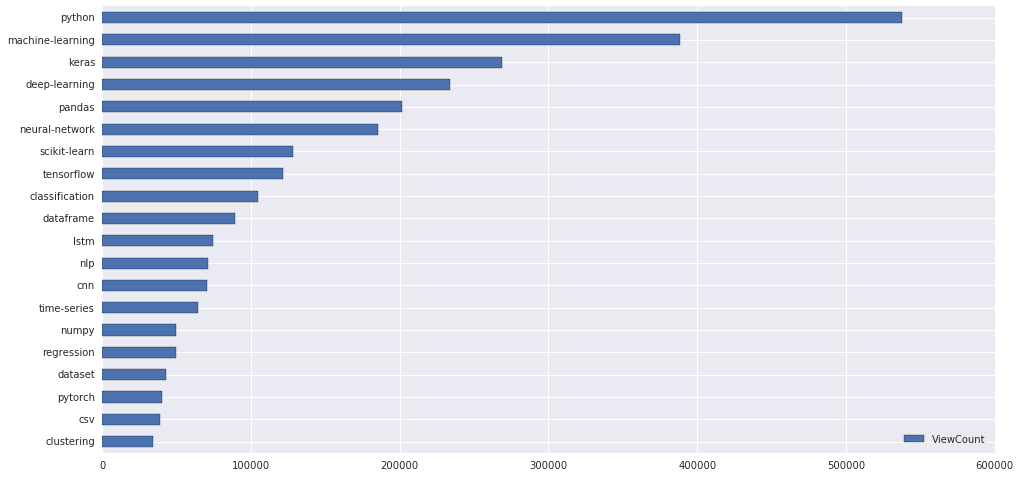

In [29]:
# how many times each tag was viewed
#we will use pandas.dataFrame.iterrows()

tag_view_count=dict()

for index,row in questions.iterrows():
    for tag in row['Tags']:
        if tag in tag_view_count:
            tag_view_count[tag] += row['ViewCount']
        else:
            tag_view_count[tag] = row['ViewCount']

    

tag_view_count=pd.DataFrame.from_dict(tag_view_count,orient='index')
tag_view_count.rename(columns={0:'ViewCount'},inplace=True)
tag_view_count.head()
most_viewed=tag_view_count.sort_values(by='ViewCount').tail(20)
most_viewed.plot(kind='barh',figsize=(16,8))

## Enter Domain Knowledge
Keras, scikit-learn, TensorFlow are all Python libraries that allow their users to employ deep learning (a type of neural network).

Most of the top tags are all intimately related with one central machine learning theme: deep learning. If we want to be very specific, we can suggest the creation of Python content that uses deep learning for classification problems (and other variations of this suggestion).

At the glance of an eye, someone with sufficient domain knowledge can tell that the most popular topic at the moment, as shown by our analysis, is deep learning.

## Just a Fad?

Before we officially make our recommendation, it would be nice to solidy our findings with additional proof. More specifically, one thing that comes to mind is "Is deep learning just a fad?" Ideally, the content we decide to create will be the most useful for as long as possible. Could interest in deep learning be slowing down? Back to [SEDE](https://data.stackexchange.com/datascience/query/edit/1284900)

The file all_questions.csv holds the result of the query below — this query fetches all of the questions ever asked on DSSE, their dates and tags.

SELECT Id, CreationDate, Tags

  FROM posts
  
 WHERE PostTypeId = 1;
 
In this we will track the interest in deep learning across time. We will:

- Count how many deep learning questions are asked per time period.
- The total amount of questions per time period.
- How many deep learning questions there are relative to the total amount of questions per time period.

In [30]:
all_q=pd.read_csv("all_questions.csv",parse_dates=["CreationDate"])

In [31]:
#To clean the Tags column
all_q["Tags"] = all_q["Tags"].str.replace("^<|>$", "").str.split("><")

Before deciding which questions should be classified as being deep learning questions, we should decide what tags are deep learning tags.

The definition of what constitutes a deep learning tag we'll use is: a tag that belongs to the list ["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"].

This list was obtained by looking at all the tags in most_used and seeing which ones had any relation to deep learning. You can use Google and read the tags descriptions to reach similar results.

We'll now create a function that assigns 1 to deep learning questions and 0 otherwise; and we use it.

In [32]:
def class_deep_learning(tags):
    for tag in tags:
        if tag in ["lstm", "cnn", "scikit-learn", "tensorflow",
                   "keras", "neural-network", "deep-learning"]:
            return 1
        else:
            return 0
        
all_q["DeepLearning"]=all_q["Tags"].apply(class_deep_learning)
all_q.sample(6)

,Id,CreationDate,Tags,DeepLearning
12166,61657,2019-10-13 03:12:07,"[machine-learning, classification, class-imbal...",0
978,45799,2019-02-19 08:55:23,"[python, pandas]",0
16925,32162,2018-05-25 14:18:01,"[keras, accuracy]",1
4440,57302,2019-08-09 09:46:37,"[machine-learning, feature-selection, data, 3d...",0
5213,39327,2018-10-08 02:30:16,"[machine-learning, data-mining, predictive-mod...",0
19195,54965,2019-07-03 07:20:23,"[machine-learning, recommender-system]",0


Lets track it quarterly

In [33]:
all_q=all_q[all_q["CreationDate"].dt.year<2020]

Let's create a column that identifies the quarter in which a question was asked.

In [34]:
def quarter_fetch(datetime):
    year=str(datetime.year)[-2:]
    quarter=str(((datetime.month-1) // 3) + 1)
    return "{Y}Q{q}".format(Y=year,q=quarter)
all_q["Quarter"]=all_q["CreationDate"].apply(quarter_fetch)

In [35]:
all_q.head(5)

,Id,CreationDate,Tags,DeepLearning,Quarter
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",0,19Q1
1,45418,2019-02-12 00:50:39,[neural-network],1,19Q1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",0,19Q1
3,45426,2019-02-12 04:51:49,[keras],1,19Q1
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",0,19Q1


we'll group by quarter and:

- Count the number of deep learning questions.
- Count the total number of questions.
- Compute the ratio between the two numbers above.

In [37]:
quarterly=all_q.groupby("Quarter").agg({'DeepLearning':['sum','size']})

In [38]:
quarterly

DeepLearning      
                 sum  size
Quarter                   
14Q2               3   157
14Q3               4   189
14Q4               4   216
15Q1               5   190
15Q2               6   284
15Q3              13   311
15Q4              19   382
16Q1              38   516
16Q2              45   518
16Q3              69   585
16Q4              76   527
17Q1             105   698
17Q2             105   647
17Q3             116   714
17Q4             146   898
18Q1             214  1221
18Q2             260  1448
18Q3             329  1512
18Q4             260  1294
19Q1             411  1987
19Q2             504  2393
19Q3             508  2394
19Q4             411  2036

In [39]:
quarterly.columns = ['DeepLearningQuestions', 'TotalQuestions']
quarterly["DeepLearningRate"] = quarterly["DeepLearningQuestions"]\
                                /quarterly["TotalQuestions"]

In [40]:
# The following is done to help with visualizations later.
quarterly.reset_index(inplace=True)
quarterly.sample(5)

,Quarter,DeepLearningQuestions,TotalQuestions,DeepLearningRate
1,14Q3,4,189,0.021164
17,18Q3,329,1512,0.217593
19,19Q1,411,1987,0.206844
3,15Q1,5,190,0.026316
14,17Q4,146,898,0.162584


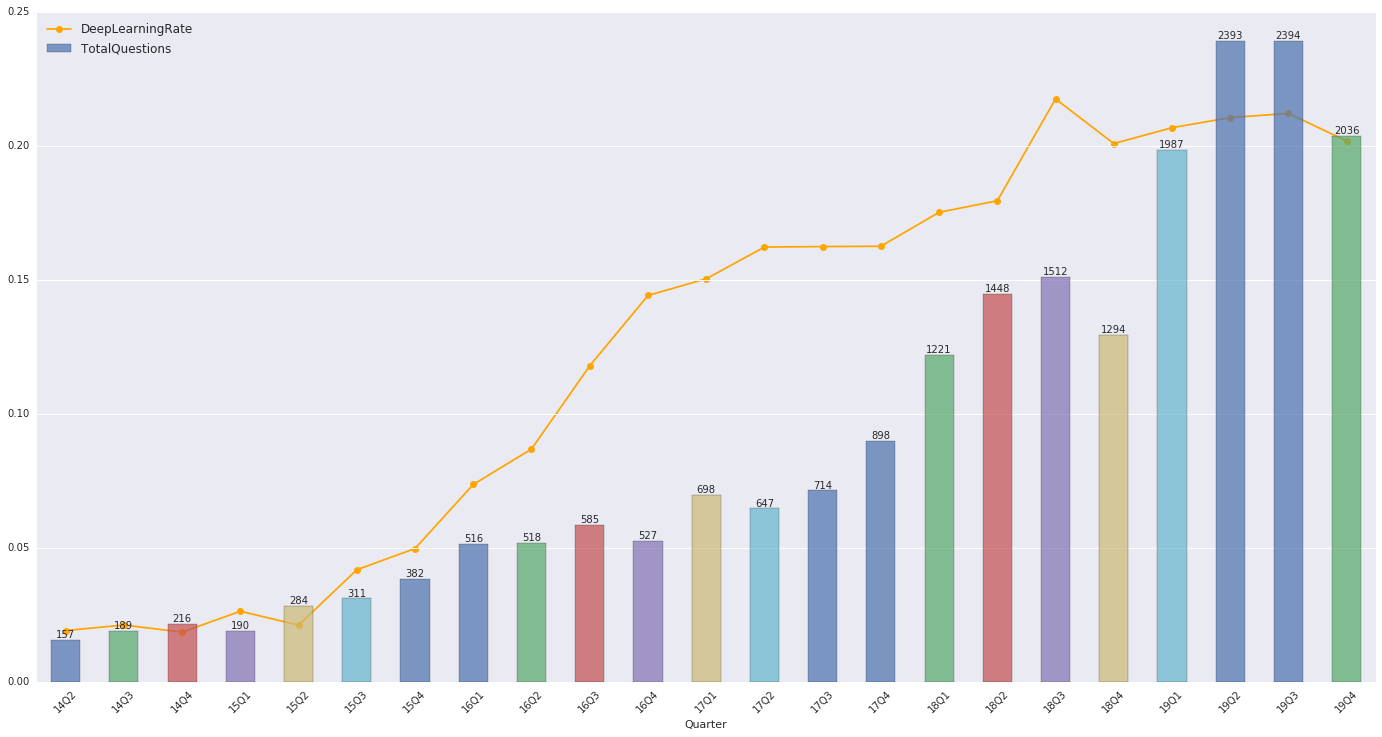

In [41]:
 ax1 = quarterly.plot(x="Quarter", y="DeepLearningRate",
                      kind="line", linestyle="-", marker="o", color="orange",
                    figsize=(24,12)
                    )

ax2 = quarterly.plot(x="Quarter", y="TotalQuestions",
                     kind="bar", ax=ax1, secondary_y=True, alpha=0.7, rot=45)

for idx, t in quarterly["TotalQuestions"].iteritems():
    ax2.text(idx, t, str(t), ha="center", va="bottom")
xlims = ax1.get_xlim()

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 12})


for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)

It seems that deep learning questions was a high-growth trend since the start of DSSE and it looks like it is plateauing. There is no evidence to suggest that interest in deep learning is decreasing and so we maintain our previous idea of proposing that we create deep learning content.